----------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

# 計算時間
import time

--------
# ２．実験設定

## 2.1 実験設定

In [2]:
### 実験データの設定 ###
TARGET = "PM_US Post"
THRESHOLD = 2  # 外れ値除外の閾値

### 実験設定 ###
SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10000  # 試行回数（標本平均を求める回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード
SEED = 0

### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD = "kmeans"  # "gmm" or "kmeans" or "xmeans"
N_CLUSTERS = 8  # クラスタ数
K_MIN = 2
K_MAX = 10

# 特徴量選択
ALLOCATION_METHODS = [
    "Proportional",
    "Post",
    "Optimal",
]
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = 2  # 選択される最大の特徴量(特徴量選択ありの場合)


### 可視化 ###
TITLE_SIZE = 20
LABEL_SIZE = 15
TICK_SIZE = 12.5

## 2.2 手法の名前

In [3]:
if CLUSTERING_METHOD == "kmeans":
    METHOD_NAME = "SFS-Kmeans-Var"

-----------
# ３．データの前処理

## 3.1 データ読み込み

In [4]:
# df_Beijing = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\BeijingPM20100101_20151231.csv"
# )
# df_Chengdu = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ChengduPM20100101_20151231.csv"
# )
# df_Guangzhou = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\GuangzhouPM20100101_20151231.csv"
# )
# df_Shanghai = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ShanghaiPM20100101_20151231.csv"
# )
# df_Shenyang = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ShenyangPM20100101_20151231.csv"
# )


In [5]:
df_Beijing = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\BeijingPM20100101_20151231.csv"
)
df_Chengdu = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ChengduPM20100101_20151231.csv"
)
df_Guangzhou = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\GuangzhouPM20100101_20151231.csv"
)
df_Shanghai = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ShanghaiPM20100101_20151231.csv"
)
df_Shenyang = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ShenyangPM20100101_20151231.csv"
)

In [6]:
df_Beijing["city"] = "Beijing"
df_Chengdu["city"] = "Chengdu"
df_Guangzhou["city"] = "Guangzhou"
df_Shanghai["city"] = "Shanghai"
df_Shenyang["city"] = "Shenyang"

In [7]:
df_all = pd.concat(
    [df_Beijing, df_Chengdu, df_Guangzhou, df_Shanghai, df_Shenyang],
    axis=0,
    ignore_index=True,
)

In [8]:
features_list_con = [
    "DEWP",
    "TEMP",
    "HUMI",
    "PRES",
    "Iws",
    "precipitation",
    "Iprec",
]
features_list_cat = ["city", "season", "cbwd"]
features_list = features_list_con + features_list_cat


In [9]:
df_all_encoded = pd.get_dummies(df_all, columns=features_list_cat)
print(df_all_encoded)

           No  year  month  day  hour  PM_Dongsi  PM_Dongsihuan  \
0           1  2010      1    1     0        NaN            NaN   
1           2  2010      1    1     1        NaN            NaN   
2           3  2010      1    1     2        NaN            NaN   
3           4  2010      1    1     3        NaN            NaN   
4           5  2010      1    1     4        NaN            NaN   
...       ...   ...    ...  ...   ...        ...            ...   
262915  52580  2015     12   31    19        NaN            NaN   
262916  52581  2015     12   31    20        NaN            NaN   
262917  52582  2015     12   31    21        NaN            NaN   
262918  52583  2015     12   31    22        NaN            NaN   
262919  52584  2015     12   31    23        NaN            NaN   

        PM_Nongzhanguan  PM_US Post  DEWP  ...  city_Shenyang  season_1.0  \
0                   NaN         NaN -21.0  ...          False       False   
1                   NaN         NaN -21.0

In [10]:
X_COLUMNS_DICT = {}
cat_columns_list = []

for f in features_list_con:
    X_COLUMNS_DICT[f] = [f]
for f in features_list_cat:
    col_list = [col for col in df_all_encoded.columns if col.startswith(f)]
    X_COLUMNS_DICT[f] = col_list
    cat_columns_list = cat_columns_list + col_list

X_COLUMNS_LIST = features_list_con + cat_columns_list
columns_list = [TARGET] + features_list_con + cat_columns_list

print("X_COLUMNS_DICT:", X_COLUMNS_DICT)
print("X_COLUMNS_LIST", X_COLUMNS_LIST)
print("columns_list:", columns_list)

X_COLUMNS_DICT: {'DEWP': ['DEWP'], 'TEMP': ['TEMP'], 'HUMI': ['HUMI'], 'PRES': ['PRES'], 'Iws': ['Iws'], 'precipitation': ['precipitation'], 'Iprec': ['Iprec'], 'city': ['city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang'], 'season': ['season_1.0', 'season_2.0', 'season_3.0', 'season_4.0'], 'cbwd': ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']}
X_COLUMNS_LIST ['DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec', 'city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']
columns_list: ['PM_US Post', 'DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec', 'city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']


In [11]:
df_2014 = df_all_encoded[df_all["year"] == 2014][columns_list]
df_2015 = df_all_encoded[df_all["year"] == 2015][columns_list]
print(df_2014)
print(df_2015)

        PM_US Post  DEWP  TEMP   HUMI    PRES     Iws  precipitation  Iprec  \
35064         53.0 -20.0   7.0  12.00  1014.0  143.48            0.0    0.0   
35065         65.0 -20.0   7.0  12.00  1013.0  147.50            0.0    0.0   
35066         70.0 -20.0   6.0  13.00  1013.0  151.52            0.0    0.0   
35067         79.0 -20.0   6.0  13.00  1013.0  153.31            0.0    0.0   
35068         92.0 -18.0   3.0  19.00  1012.0    0.89            0.0    0.0   
...            ...   ...   ...    ...     ...     ...            ...    ...   
254155        38.0 -20.0 -10.0  43.68  1026.0   51.00            0.0    0.0   
254156        36.0 -21.0 -10.0  40.04  1026.0   55.00            0.0    0.0   
254157        31.0 -21.0 -11.0  43.36  1027.0   59.00            0.0    0.0   
254158        30.0 -21.0 -11.0  43.36  1027.0   64.00            0.0    0.0   
254159        26.0 -21.0 -12.0  46.98  1027.0   68.00            0.0    0.0   

        city_Beijing  city_Chengdu  ...  city_Sheny

## 3.2 欠損値除去

In [12]:
def remove_nan(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 各列に対して、pd.to_numericを使用して数値に変換（エラーがあればNaNにする）
    df_numeric = data.apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # 数値に変換できなかった行を抽出（NaNを含む行）
    df_excluded = data[df_numeric.isna().any(axis=1)]

    # NaNを含む行を削除
    df_clean = df_numeric.dropna()

    return df_excluded, df_clean

In [13]:
_, df_2014_clean = remove_nan(df_2014)
_, df_2015_clean = remove_nan(df_2015)

print("全データ数（訓練）：", len(df_2014))
print("全データ数（テスト）：", len(df_2015))
print("欠損値除去後のデータ数（訓練）：", len(df_2014_clean))
print("欠損値除去後のデータ数（テスト）：", len(df_2015_clean))

全データ数（訓練）： 43800
全データ数（テスト）： 43800
欠損値除去後のデータ数（訓練）： 40334
欠損値除去後のデータ数（テスト）： 39098


## 3.3 外れ値除去

In [14]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [15]:
df_train = remove_outliers_zscore(
    data=df_2014_clean, metric=TARGET, threshold=THRESHOLD
)
df_train = df_train.reset_index(drop=True)  # 行を詰める
df_test = remove_outliers_zscore(data=df_2015_clean, metric=TARGET, threshold=THRESHOLD)
df_test = df_test.reset_index(drop=True)  # 行を詰める

print("欠損値と外れ値除外後のデータ数（訓練）:", len(df_train))
print("欠損値と外れ値除外後のデータ数（テスト）:", len(df_test))

欠損値と外れ値除外後のデータ数（訓練）: 38559
欠損値と外れ値除外後のデータ数（テスト）: 37237


## 3.4 X, yに分割

In [16]:
X_train = df_train[X_COLUMNS_LIST].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[X_COLUMNS_LIST].to_numpy()
y_test = df_test[TARGET].to_numpy()

## 3.5 標準化

In [17]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
# ４．特徴量選択

In [18]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}

### Allocation_in_Wrapper Class で特徴量選択

In [19]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        X_columns_dict: dict,
        X_columns_list: list,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
        allocation_method: str = "Proportional",
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
    ):
        self.X_columns_dict = X_columns_dict
        self.X_columns_list = X_columns_list
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max
        self.allocation_method = allocation_method
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Allocation_in_Wrapper":
        X, y = check_X_y(X, y)
        all_features = list(self.X_columns_dict.keys())

        features_score_dict = {}

        # 選ばれた特徴量と残っている特徴量の初期化
        current_features = []
        remaining_features = all_features

        if self.select_maximum_features == "no":
            best_score = -np.inf

        while len(current_features) < self.maximum_features_to_select:
            best_feature = None  # 選ぶ特徴量の初期化

            if self.select_maximum_features == "yes":
                best_score = -np.inf

            for feature in remaining_features:
                temp_features = current_features + [feature]
                temp_columns = sum((self.X_columns_dict[f] for f in temp_features), [])
                temp_columns_index = [
                    self.X_columns_list.index(col) for col in temp_columns
                ]
                score, n_clusters = self.crit(X[:, temp_columns_index], y)

                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_N_cluster_size = self.N_cluster_size
                    best_n_clusters = n_clusters
                    best_n_cluster_size = self.n_cluster_size

            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                    "best_N_cluster_size:",
                    best_N_cluster_size,
                    "best_n_cluster_size:",
                    best_n_cluster_size,
                )

                features_score_dict[str(num_of_features)] = best_score  # 確認用
            else:
                break

        self.selected_features = current_features
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        if self.allocation_method == "Proportional":
            var = self.cauculate_var_proportional(X, y)
        if self.allocation_method == "Post":
            var = self.cauculate_var_proportional(X, y)
        if self.allocation_method == "Optimal":
            var = self.cauculate_var_optimal(X, y)
        score = -var

        return score, n_clusters

    def cauculate_var_proportional(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        self.n_cluster_size = self.proportional(X, y)
        H = np.where(self.n_cluster_size > 0)[0]
        N = np.sum(np.isin(self.N_cluster_label, H))
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in H])
        n_h = self.n_cluster_size[H]
        N_h = self.N_cluster_size[H]
        var = (1 / int(N) ** 2) * (np.sum((N_h**2 * S) / n_h) - np.sum(N_h * S))
        return var

    def cauculate_var_optimal(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        self.n_cluster_size, H = self.optimal(X, y)
        N = np.sum(np.isin(self.N_cluster_label, H))
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in H])
        n_h = self.n_cluster_size
        N_h = self.N_cluster_size[H]
        var = (1 / int(N) ** 2) * ((np.sum((N_h**2 * S) / n_h)) - np.sum(N_h * S))

        return var

    def proportional(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )
        return n_cluster_size

    def optimal(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        cluster_size_all = np.bincount(self.N_cluster_label)
        cluster_size_for_optimal = []
        labels_for_optimal = []
        for i in range(len(cluster_size_all)):
            if cluster_size_all[i] >= 2:
                cluster_size_for_optimal.append(cluster_size_all[i])
                labels_for_optimal.append(i)
        n_clusters_for_optimal = len(cluster_size_for_optimal)
        cluster_size_for_optimal = np.array(cluster_size_for_optimal)

        self.m = np.full(n_clusters_for_optimal, self.m_value)

        S = np.array([np.var(y[self.N_cluster_label == h]) for h in labels_for_optimal])
        d = (cluster_size_for_optimal**2) * S

        n_cluster_size = self.m.copy()  # 初期値
        M = self.M.copy() if self.M is not None else cluster_size_for_optimal.copy()
        I = np.arange(n_clusters_for_optimal)  # noqa #クラスタのインデックス

        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(n_clusters_for_optimal)
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size, labels_for_optimal

    def get_selected_features(self):
        return self.selected_features  # 選択された特徴量のインデックス

    def get_features_score_dict(self):
        return self.features_score_dict

In [20]:
def process_allocation_in_wrapper(
    instance: "Allocation_in_Wrapper", X: NDArray, y: NDArray
) -> tuple[list, dict[int, float]]:
    instance.fss(X, y)
    selected_features = np.array(instance.get_selected_features())
    features_score_dict = instance.get_features_score_dict()

    return selected_features, features_score_dict

### インスタンスのリスト作成

In [21]:
instances = []
for allocation_method in ALLOCATION_METHODS:
    instances.append(
        (
            allocation_method,
            Allocation_in_Wrapper(
                X_columns_dict=X_COLUMNS_DICT,
                X_columns_list=X_COLUMNS_LIST,
                maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                n_clusters=N_CLUSTERS,
                clustering_method=CLUSTERING_METHOD,
                random_state=RANDOM_STATE,
                select_maximum_features=SELECT_MAXIMUM_FEATURES,
                k_min=K_MIN,
                k_max=K_MAX,
                allocation_method=allocation_method,
                sample_size=SAMPLE_SIZE,
                n_trials=N_TRIALS,
                m_value=m_VALUE,
            ),
        )
    )

### Allocation in Wrapper の実施

In [22]:
features_score_dict_dict = {}

# 各インスタンスに対して処理を実行
for allocation_method, instance in instances:
    print("[", allocation_method, "]")
    start_time = time.time()
    selected_features, features_score_dict = process_allocation_in_wrapper(
        instance, X_train_std, y_train
    )
    end_time = time.time()

    SELECTED_FEATURES_DICT[allocation_method] = selected_features
    TIME_DICT[allocation_method] = end_time - start_time

    features_score_dict_dict[allocation_method] = features_score_dict

[ Proportional ]


c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: ['city'] , score: -16.899905260579065 best_n_clusters: 5 best_N_cluster_size: [8042 7913 7645 7618 7341] best_n_cluster_size: [20 21 20 20 19]
num_of_features: 2 current_features: ['city', 'season'] , score: -16.353819979816656 best_n_clusters: 8 best_N_cluster_size: [8042 7913 1507 1893 5493 5834 2125 5752] best_n_cluster_size: [20 21  4  5 14 15  6 15]
[ Post ]


c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: ['city'] , score: -16.899905260579065 best_n_clusters: 5 best_N_cluster_size: [8042 7913 7645 7618 7341] best_n_cluster_size: [20 21 20 20 19]
num_of_features: 2 current_features: ['city', 'season'] , score: -16.353819979816656 best_n_clusters: 8 best_N_cluster_size: [8042 7913 1507 1893 5493 5834 2125 5752] best_n_cluster_size: [20 21  4  5 14 15  6 15]
[ Optimal ]


c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: ['city'] , score: -16.441600724544674 best_n_clusters: 5 best_N_cluster_size: [8042 7913 7645 7618 7341] best_n_cluster_size: [17 17 20 25 21]
num_of_features: 2 current_features: ['city', 'season'] , score: -15.774629255904149 best_n_clusters: 8 best_N_cluster_size: [8042 7913 1507 1893 5493 5834 2125 5752] best_n_cluster_size: [17 17  3  6 19 18  7 13]


In [23]:
print(features_score_dict_dict)

{'Proportional': {'1': -16.899905260579065, '2': -16.353819979816656}, 'Post': {'1': -16.899905260579065, '2': -16.353819979816656}, 'Optimal': {'1': -16.441600724544674, '2': -15.774629255904149}}


## 4.4 特徴量選択の結果

### スコア（-分散）の推移

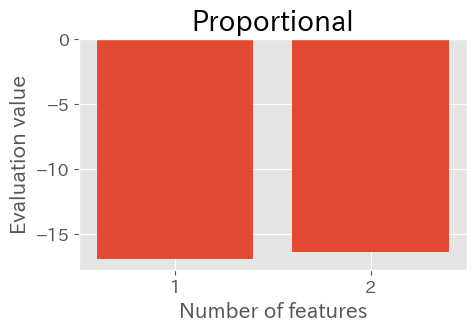

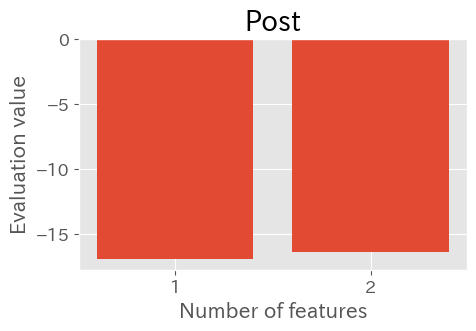

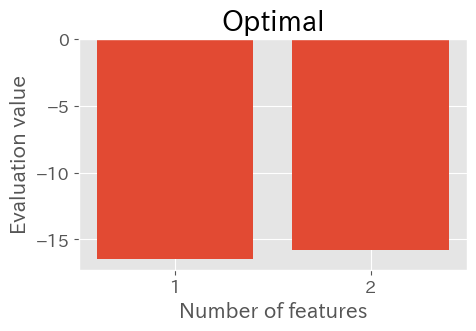

In [24]:
for allocation_method, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_score_dict_dict[allocation_method].keys(),
        features_score_dict_dict[allocation_method].values(),
    )
    plt.title(f"{allocation_method}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Evaluation value", fontsize=LABEL_SIZE)
    # plt.ylim(,)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 分散削減率の推移

In [25]:
def cauculate_var_random(y: NDArray, seed: int, n_trials: int, sample_size) -> float:
    np.random.seed(seed)
    y_hats = []
    for i in range(n_trials):
        sample = np.random.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random

In [26]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

In [27]:
features_reduction_rate_dict_dict = {}
for allocation_method, score_dict in features_score_dict_dict.items():
    features_reduction_rate_dict_dict[allocation_method] = {}
    for n_features, score in score_dict.items():
        reduction_rate = (1 - (-score / VAR_RANDOM_TRAIN)) * 100
        features_reduction_rate_dict_dict[allocation_method][n_features] = (
            reduction_rate
        )

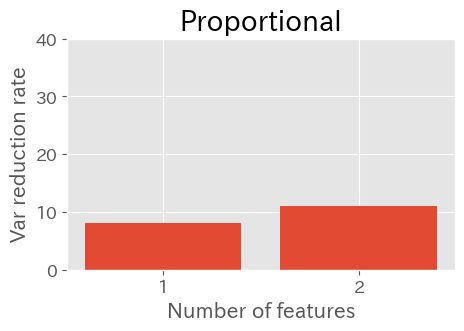

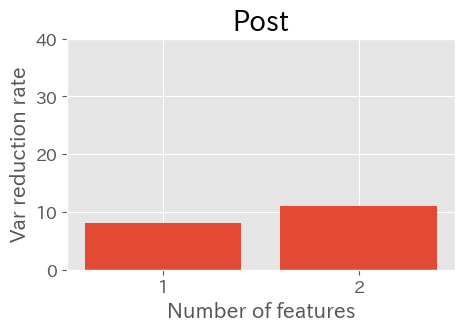

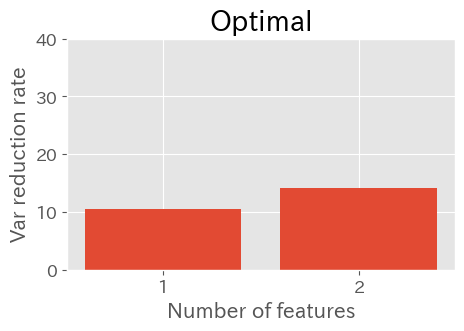

In [28]:
for allocation_method, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_reduction_rate_dict_dict[allocation_method].keys(),
        features_reduction_rate_dict_dict[allocation_method].values(),
    )
    plt.title(f"{allocation_method}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Var reduction rate", fontsize=LABEL_SIZE)
    plt.ylim(0, 40)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 特徴量選択の結果

In [29]:
for allocation_method in ALLOCATION_METHODS:
    print(f"【{allocation_method}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[allocation_method])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[allocation_method], 3)} s")
    print()

【Proportional】
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：2.738 s

【Post】
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：2.294 s

【Optimal】
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：1.9 s



# ５．クラスタリングと標本配分

## 5.1 クラスタリング

### 準備

In [30]:
def compute_bic(X: NDArray, kmeans: KMeans) -> float:
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X: NDArray, k_min: int, k_max: int) -> KMeans:
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [31]:
def clustering(
    X_train: NDArray,
    X_test: NDArray,
    allocation_methods: list,
    clustering_method: str,
    n_clusters: int,
    random_state: int,
    k_min: int,
    k_max: int,
    selected_features_dict: dict,
    X_columns_dict: dict,
    X_columns_list: list,
) -> tuple[dict, dict, dict, dict]:
    cluster_label_dict_train = {}
    cluster_size_dict_train = {}
    cluster_label_dict_test = {}
    cluster_size_dict_test = {}

    for allocation_method in allocation_methods:
        if clustering_method == "kmeans":
            model = KMeans(n_clusters=n_clusters, random_state=random_state)
        if clustering_method == "gmm":
            model = GaussianMixture(
                n_components=n_clusters, random_state=random_state, init_params="kmeans"
            )
        if clustering_method == "xmeans":
            model = xmeans(X_train, k_min=k_min, k_max=k_max)

        features = selected_features_dict[allocation_method]
        columns = [col for f in features for col in X_columns_dict.get(f, [])]
        columns_index = [X_columns_list.index(col) for col in columns]

        cluster_label_train = model.fit_predict(X_train[:, columns_index])
        cluster_size_train = np.bincount(cluster_label_train)
        cluster_label_test = model.predict(X_test[:, columns_index])
        cluster_size_test = np.bincount(cluster_label_test, minlength=n_clusters)

        cluster_label_dict_train[allocation_method] = cluster_label_train
        cluster_size_dict_train[allocation_method] = cluster_size_train
        cluster_label_dict_test[allocation_method] = cluster_label_test
        cluster_size_dict_test[allocation_method] = cluster_size_test

    return (
        cluster_label_dict_train,
        cluster_size_dict_train,
        cluster_label_dict_test,
        cluster_size_dict_test,
    )

### クラスタリングの実施

In [32]:
(
    CLUSTER_LABEL_DICT_TRAIN,
    CLUSTER_SIZE_DICT_TRAIN,
    CLUSTER_LABEL_DICT_TEST,
    CLUSTER_SIZE_DICT_TEST,
) = clustering(
    X_train=X_train_std,
    X_test=X_test_std,
    allocation_methods=ALLOCATION_METHODS,
    clustering_method=CLUSTERING_METHOD,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
    X_columns_dict=X_COLUMNS_DICT,
    X_columns_list=X_COLUMNS_LIST,
)

In [33]:
def cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict: dict[str, NDArray],
) -> dict[str, list[int]]:
    cluster_size_dict_for_allocation = {}
    for allo, cluster_size in cluster_size_dict.items():
        if allo == "Optimal":
            min_n_h = 2
        else:
            min_n_h = 1
        cluster_size_list = []
        for i in range(len(cluster_size)):
            if cluster_size[i] >= min_n_h:
                cluster_size_list.append(cluster_size[i])
        cluster_size_dict_for_allocation[allo] = cluster_size_list
    return cluster_size_dict_for_allocation


def cauculate_unique_label_dict_for_allocation(
    cluster_size_dict: dict[str, NDArray],
) -> dict[str, list[int]]:
    unique_label_dict_for_allocation = {}
    for allo, cluster_size in cluster_size_dict.items():
        if allo == "Optimal":
            min_n_h = 2
        else:
            min_n_h = 1
        labels = []
        for i in range(len(cluster_size)):
            if cluster_size[i] >= min_n_h:
                labels.append(i)
        unique_label_dict_for_allocation[allo] = labels
    return unique_label_dict_for_allocation

In [34]:
CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN
)
UNIQUE_LABEL_DICT_FOR_ALLOCATION_TRAIN = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN
)
CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST
)
UNIQUE_LABEL_DICT_FOR_ALLOCATION_TEST = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST
)

### クラスタリング結果

In [35]:
print("【訓練データ】")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method}：{CLUSTER_SIZE_DICT_TRAIN[allocation_method]}")
    print(f"標本配分用：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN[allocation_method]}")

print()

print("【テストデータ】")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method}：{CLUSTER_SIZE_DICT_TEST[allocation_method]}")
    print(f"標本配分用：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST[allocation_method]}")

【訓練データ】
Proportional：[8042 7913 1507 1893 5493 5834 2125 5752]
標本配分用：[8042, 7913, 1507, 1893, 5493, 5834, 2125, 5752]
Post：[8042 7913 1507 1893 5493 5834 2125 5752]
標本配分用：[8042, 7913, 1507, 1893, 5493, 5834, 2125, 5752]
Optimal：[8042 7913 1507 1893 5493 5834 2125 5752]
標本配分用：[8042, 7913, 1507, 1893, 5493, 5834, 2125, 5752]

【テストデータ】
Proportional：[8498 6956 1430 1707 4971 5384 2049 6242]
標本配分用：[8498, 6956, 1430, 1707, 4971, 5384, 2049, 6242]
Post：[8498 6956 1430 1707 4971 5384 2049 6242]
標本配分用：[8498, 6956, 1430, 1707, 4971, 5384, 2049, 6242]
Optimal：[8498 6956 1430 1707 4971 5384 2049 6242]
標本配分用：[8498, 6956, 1430, 1707, 4971, 5384, 2049, 6242]


## 5.2 標本配分

### 基底クラス

In [36]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        allocation_method: str,
        cluster_size_dict_for_allocation: dict,
    ):
        self.sample_size = sample_size
        self.random_state = random_state
        self.allocation_method = allocation_method
        self.N = np.array(cluster_size_dict_for_allocation[self.allocation_method])

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

### ① 比例配分（Proportional）

In [37]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

### ② 事後層化（Post）

In [38]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

### ③ 最適標本配分（Optimal）

In [39]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        allocation_method: str,
        cluster_label_dict: dict,
        cluster_size_dict_for_allocation: dict,
        unique_label_dict_for_allocation: dict,
        m_value: int,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
    ):
        super().__init__(
            sample_size,
            random_state,
            allocation_method,
            cluster_size_dict_for_allocation,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.cluster_label = cluster_label_dict[self.allocation_method]
        self.N_for_optimal = np.array(cluster_size_dict_for_allocation["Optimal"])
        self.labels = unique_label_dict_for_allocation["Optimal"]
        self.m_value = m_value  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array(
            [np.var(y[self.cluster_label == h]) for h in self.labels]
        )  # 層hのデータが１つのときはS[h]は0になる
        d = (self.N_for_optimal**2) * S  # (H, )

        self.m = np.full(len(self.labels), self.m_value)
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N_for_optimal.copy()
        I = np.arange(len(self.labels))  # noqa #クラスタのインデックス配列
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(len(self.labels))
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n >= self.m_value
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

### ポリシーの生成

In [40]:
def create_policies(
    sample_size: int,
    random_state: int,
    m_value: int,
    cluster_label_dict: dict,
    cluster_size_dict_for_allocation: list,
    unique_label_dict_for_allocation: list,
    allocation_methods: list,
) -> list[BaseAllocation]:
    policies: list[BaseAllocation] = []
    if "Proportional" in allocation_methods:
        policies.append(
            Proportional(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Proportional",
                cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
            )
        )
    if "Post" in allocation_methods:
        policies.append(
            Post(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Post",
                cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
            )
        )
    if "Optimal" in allocation_methods:
        policies.append(
            Optimal(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Optimal",
                cluster_label_dict=cluster_label_dict,
                cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                unique_label_dict_for_allocation=unique_label_dict_for_allocation,
                m_value=m_value,
                M=None,
            )
        )

    return policies

In [41]:
policies_train = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TRAIN,
    m_value=m_VALUE,
    allocation_methods=ALLOCATION_METHODS,
)

policies_test = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TEST,
    m_value=m_VALUE,
    allocation_methods=ALLOCATION_METHODS,
)

### 標本配分の実施

In [42]:
def cauculate_allocation_dict(
    X: NDArray, y: NDArray, policies: list
) -> dict[str, NDArray]:
    allocation_dict = {}
    for policy in policies:
        n = policy.solve(X, y)
        allocation_dict[policy.__class__.__name__] = n

    return allocation_dict

In [43]:
ALLOCATION_DICT_TRAIN = cauculate_allocation_dict(
    X=X_train_std, y=y_train, policies=policies_train
)
ALLOCATION_DICT_TEST = cauculate_allocation_dict(
    X=X_test_std, y=y_test, policies=policies_test
)

### 標本配分の結果

In [44]:
print("訓練データ")
print(f"【{METHOD_NAME}】")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method} : {ALLOCATION_DICT_TRAIN[allocation_method]}")

print()

print("テストデータ")
print(f"【{METHOD_NAME}】")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method} : {ALLOCATION_DICT_TEST[allocation_method]}")

訓練データ
【SFS-Kmeans-Var】
Proportional : [20 21  4  5 14 15  6 15]
Post : [100]
Optimal : [17 17  3  6 19 18  7 13]

テストデータ
【SFS-Kmeans-Var】
Proportional : [22 19  4  5 13 14  6 17]
Post : [100]
Optimal : [18 17  3  6 18 18  5 15]


---------------------
# ６．評価

## 6.1 標本平均の分散を計算（単純無作為抽出）

In [45]:
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

print(f"訓練データでの標本平均の分散 (Random) : {VAR_RANDOM_TRAIN}")
print(f"テストデータでの標本平均の分散 (Random) : {VAR_RANDOM_TEST}")

訓練データでの標本平均の分散 (Random) : 18.390855190079
テストデータでの標本平均の分散 (Random) : 14.77756672


## 6.2 標本平均の分散を計算（層化抽出）

### 標本平均を計算する関数

In [46]:
def estimate_y_mean_proportional(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_proportional: list,
    unique_label_for_proportional: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_proportional)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_proportional:  # n.shape[0]:層の数
        i += 1
        if n[i] > 0:
            sample: NDArray = np.random.choice(
                y[cluster_label == h], n[i], replace=False
            )
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_optimal(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_optimal: list,
    unique_label_for_optimal: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_optimal)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_optimal:  # n.shape[0]:層の数
        i += 1
        sample: NDArray = np.random.choice(y[cluster_label == h], n[i], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_post(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_post: list,
    unique_label_for_post: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_post)
    weights = N / N.sum()
    y_hat = 0

    all_indices = np.arange(len(y))  # 全データのインデックス
    sample_indices = np.random.choice(all_indices, n[0], replace=False)
    sample_labels = np.array([cluster_label[i] for i in sample_indices])

    for h in np.unique(sample_labels):
        index = np.where(sample_labels == h)[0]
        sample = y[sample_indices[index]]
        y_sample_mean = sample.mean()
        y_hat += y_sample_mean * weights[unique_label_for_post.index(h)]
    return y_hat

### 分散を計算する関数

In [47]:
def cauculate_var_stratified_dict(
    y: NDArray,
    seed: int,
    n_trials: int,
    allocation_dict: dict,
    cluster_label_dict: dict,
    cluster_size_dict_for_allocation: dict,
    unique_label_dict_for_allocation: dict,
) -> dict[str, float]:
    np.random.seed(seed)
    var_stratified_dict = {}

    for allocation_method, allocation in allocation_dict.items():
        y_hats = []
        for i in range(n_trials):
            if allocation_method == "Post":
                y_hat = estimate_y_mean_post(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    cluster_size_for_post=cluster_size_dict_for_allocation[
                        allocation_method
                    ],
                    unique_label_for_post=unique_label_dict_for_allocation[
                        allocation_method
                    ],
                    y=y,
                )
            elif allocation_method == "Proportional":
                y_hat = estimate_y_mean_proportional(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    cluster_size_for_proportional=cluster_size_dict_for_allocation[
                        allocation_method
                    ],
                    unique_label_for_proportional=unique_label_dict_for_allocation[
                        allocation_method
                    ],
                    y=y,
                )
            elif allocation_method == "Optimal":
                y_hat = estimate_y_mean_optimal(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    cluster_size_for_optimal=cluster_size_dict_for_allocation[
                        allocation_method
                    ],
                    unique_label_for_optimal=unique_label_dict_for_allocation[
                        allocation_method
                    ],
                    y=y,
                )
            y_hats.append(y_hat)
        y_hats = np.array(y_hats)
        var = y_hats.var()
        var_stratified_dict[allocation_method] = var

    return var_stratified_dict

### 分散を計算

In [48]:
VAR_STRATIFIED_DICT_TRAIN = cauculate_var_stratified_dict(
    y=y_train,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict=ALLOCATION_DICT_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TRAIN,
)
VAR_STRATIFIED_DICT_TEST = cauculate_var_stratified_dict(
    y=y_test,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict=ALLOCATION_DICT_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TEST,
)

In [49]:
print(f"【{METHOD_NAME}】")
print("訓練データでの標本平均の分散")
print(VAR_STRATIFIED_DICT_TRAIN)
print("テストデータでの標本平均の分散")
print(VAR_STRATIFIED_DICT_TEST)

【SFS-Kmeans-Var】
訓練データでの標本平均の分散
{'Proportional': 16.6118730983969, 'Post': 18.352461326535693, 'Optimal': 15.763431833676632}
テストデータでの標本平均の分散
{'Proportional': 12.967916948644007, 'Post': 14.428390157522314, 'Optimal': 12.286077093398047}


## 6.3 分散削減率の計算

In [50]:
def cauculate_reduction_rate_dict(
    var_stratified_dict: dict, var_random: float
) -> dict[str, float]:
    reduction_rate_dict = {}
    for allocation_method, var in var_stratified_dict.items():
        reduction_rate = (1 - var / var_random) * 100
        reduction_rate_dict[allocation_method] = reduction_rate

    return reduction_rate_dict

In [51]:
REDUCTION_RATE_DICT_TRAIN = cauculate_reduction_rate_dict(
    VAR_STRATIFIED_DICT_TRAIN, VAR_RANDOM_TRAIN
)

REDUCTION_RATE_DICT_TEST = cauculate_reduction_rate_dict(
    VAR_STRATIFIED_DICT_TEST, VAR_RANDOM_TEST
)

In [52]:
print(f"【{METHOD_NAME}】")
print("訓練データでの標本平均の分散の削減率")
print(REDUCTION_RATE_DICT_TRAIN)
print("テストデータでの標本平均の分散の削減率")
print(REDUCTION_RATE_DICT_TEST)

【SFS-Kmeans-Var】
訓練データでの標本平均の分散の削減率
{'Proportional': 9.673188512961485, 'Post': 0.208766058709553, 'Optimal': 14.286575198633178}
テストデータでの標本平均の分散の削減率
{'Proportional': 12.245925230077336, 'Post': 2.362882665960897, 'Optimal': 16.85994503567332}


## 6.4 結果のプロット

### プロットするための関数

In [53]:
def plot_bars(
    dicts, var_random, target, method_name, title_size, label_size, tick_size
) -> plt.Figure:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    ylabels = ["Var reduction rate", "Var"]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        if i == 0:
            for bar in bars:
                yval = bar.get_height()  # 各バーの高さ（値）
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    yval,
                    round(yval, 2),
                    ha="center",
                    va="bottom",
                    fontsize=label_size,
                )  # 値をバーの上に表示
        if i == 1:
            ax.bar("Random", var_random, color="blue")
        ax.set_title(method_name, fontsize=title_size)
        ax.set_ylabel(ylabels[i], fontsize=label_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.set_ylim(0, 50)
    plt.tight_layout()
    plt.show()

### 訓練データの結果

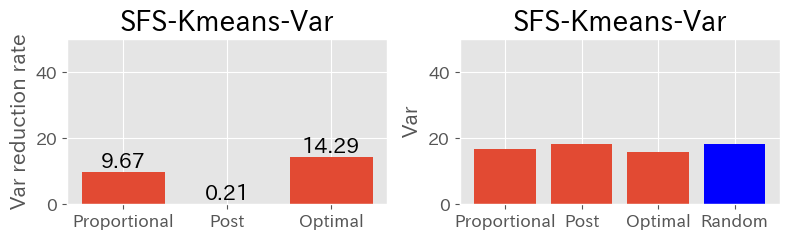

In [54]:
plot_bars(
    dicts=[
        REDUCTION_RATE_DICT_TRAIN,
        VAR_STRATIFIED_DICT_TRAIN,
    ],
    var_random=VAR_RANDOM_TRAIN,
    target=TARGET,
    method_name=METHOD_NAME,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)

### テストデータの結果

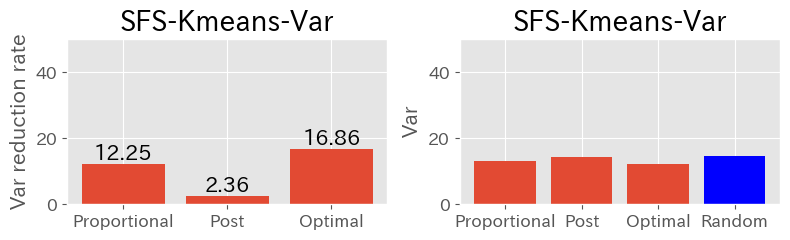

In [55]:
plot_bars(
    dicts=[
        REDUCTION_RATE_DICT_TEST,
        VAR_STRATIFIED_DICT_TEST,
    ],
    var_random=VAR_RANDOM_TEST,
    target=TARGET,
    method_name=METHOD_NAME,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)

### 確認用

In [56]:
# データ
print("全データ数（訓練）：", len(df_2014))
print("全データ数（テスト）：", len(df_2015))
print("欠損値除去後のデータ数（訓練）：", len(df_2014_clean))
print("欠損値除去後のデータ数（テスト）：", len(df_2015_clean))
print("欠損値と外れ値除外後のデータ数（訓練）:", len(df_train))
print("欠損値と外れ値除外後のデータ数（テスト）:", len(df_test))

全データ数（訓練）： 43800
全データ数（テスト）： 43800
欠損値除去後のデータ数（訓練）： 40334
欠損値除去後のデータ数（テスト）： 39098
欠損値と外れ値除外後のデータ数（訓練）: 38559
欠損値と外れ値除外後のデータ数（テスト）: 37237


In [57]:
# 特徴量選択
print(f"【{METHOD_NAME}】")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method}")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[allocation_method])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[allocation_method], 3)} s")

【SFS-Kmeans-Var】
Proportional
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：2.738 s
Post
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：2.294 s
Optimal
選択された特徴量： ['city' 'season']
特徴量選択にかかった時間：1.9 s


In [58]:
print(f"【{METHOD_NAME}】")
print("訓練データ")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method}：{CLUSTER_SIZE_DICT_TRAIN[allocation_method]}")

print("テストデータ")
for allocation_method in ALLOCATION_METHODS:
    print(f"{allocation_method}：{CLUSTER_SIZE_DICT_TEST[allocation_method]}")

【SFS-Kmeans-Var】
訓練データ
Proportional：[8042 7913 1507 1893 5493 5834 2125 5752]
Post：[8042 7913 1507 1893 5493 5834 2125 5752]
Optimal：[8042 7913 1507 1893 5493 5834 2125 5752]
テストデータ
Proportional：[8498 6956 1430 1707 4971 5384 2049 6242]
Post：[8498 6956 1430 1707 4971 5384 2049 6242]
Optimal：[8498 6956 1430 1707 4971 5384 2049 6242]


In [59]:
print("var_random_train =", VAR_RANDOM_TRAIN)
print("var_random_test =", VAR_RANDOM_TEST)

var_random_train = 18.390855190079
var_random_test = 14.77756672


In [60]:
print("var_once_dict_train =", VAR_STRATIFIED_DICT_TRAIN)
print("var_once_dict_test =", VAR_STRATIFIED_DICT_TEST)

var_once_dict_train = {'Proportional': 16.6118730983969, 'Post': 18.352461326535693, 'Optimal': 15.763431833676632}
var_once_dict_test = {'Proportional': 12.967916948644007, 'Post': 14.428390157522314, 'Optimal': 12.286077093398047}
